In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import cv2
from load_dataset import load_standardised_dataset
from image_standardisation import restore_standardised_image

In [2]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

2023-01-24 14:45:20.412944: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-24 14:45:20.589396: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-24 14:45:20.595722: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/maciej/.local/lib/python3.8/site-packages/cv2/../../lib64:
2023-01-24 14:45:20.595745: I t

In [3]:
np.random.seed(256)
path_to_dataset = Path("../SIDD_Small_sliced/Data/")
TRAIN_PAIRS_TO_LOAD = 1000
TEST_PAIRS_TO_LOAD = TRAIN_PAIRS_TO_LOAD//8
VAL_PAIRS_TO_LOAD = TRAIN_PAIRS_TO_LOAD//8
train_x, train_y, test_x, test_y, val_x, val_y = load_standardised_dataset(str(path_to_dataset), TRAIN_PAIRS_TO_LOAD, TEST_PAIRS_TO_LOAD, VAL_PAIRS_TO_LOAD)

Code stolen from:
https://github.com/VidushiBhatia/U-Net-Implementation/blob/main/U_Net_for_Image_Segmentation_From_Scratch_Using_TensorFlow_v4.ipynb

In [7]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    """
    This block uses multiple convolution layers, max pool, relu activation to create an architecture for learning. 
    Dropout can be added for regularization to prevent overfitting. 
    The block returns the activation values for next layer along with a skip connection which will be used in the decoder
    """
    # Add 2 Conv Layers with relu activation and HeNormal initialization using TensorFlow 
    # Proper initialization prevents from the problem of exploding and vanishing gradients 
    # 'Same' padding will pad the input to conv layer such that the output has the same height and width (hence, is not reduced in size) 
    conv = layers.Conv2D(n_filters, 
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = layers.Conv2D(n_filters, 
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
    
    # Batch Normalization will normalize the output of the last layer based on the batch's mean and standard deviation
    # conv = layers.BatchNormalization()(conv, training=False)

    # In case of overfitting, dropout will regularize the loss and gradient computation to shrink the influence of weights on output
    if dropout_prob > 0:     
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # Pooling reduces the size of the image while keeping the number of channels same
    # Pooling has been kept as optional as the last encoder layer does not use pooling (hence, makes the encoder block flexible to use)
    # Below, Max pooling considers the maximum of the input slice for output computation and uses stride of 2 to traverse across input image
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
    else:
        next_layer = conv

    # skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions      
    skip_connection = conv
    
    return next_layer, skip_connection

In [8]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    """
    Decoder Block first uses transpose convolution to upscale the image to a bigger size and then,
    merges the result with skip layer results from encoder block
    Adding 2 convolutions with 'same' padding helps further increase the depth of the network for better predictions
    The function returns the decoded layer output
    """
    # Start with a transpose convolution layer to first increase the size of the image
    up = layers.Conv2DTranspose(
                 n_filters,
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(prev_layer_input)

    # Merge the skip connection from previous block to prevent information loss
    merge = layers.concatenate([up, skip_layer_input], axis=3)
    
    # Add 2 Conv Layers with relu activation and HeNormal initialization for further processing
    # The parameters for the function are similar to encoder
    conv = layers.Conv2D(n_filters, 
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = layers.Conv2D(n_filters,
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv

In [9]:
def UNetCompiled(input_size=(256, 256, 3), n_filters=32, n_classes=3):
    """
    Combine both encoder and decoder blocks according to the U-Net research paper
    Return the model as output 
    """
    # Input size represent the size of 1 image (the size used for pre-processing) 
    inputs = tf.keras.Input(input_size)

    # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
    # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image 
    cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
    cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
    cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
    cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=True)
    cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 
    
    # Decoder includes multiple mini blocks with decreasing number of filters
    # Observe the skip connections from the encoder are given as input to the decoder
    # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

    # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
    # Followed by a 1x1 Conv layer to get the image to the desired size. 
    # Observe the number of channels will be equal to number of output classes
    conv9 = layers.Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = layers.Conv2D(n_classes, 1, padding='same')(conv9)
    
    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [10]:
unet = UNetCompiled(input_size=(256,256,3), n_filters=32, n_classes=3)
unet.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics=["kullback_leibler_divergence", "MAE"])

2023-01-24 14:46:37.342546: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/maciej/.local/lib/python3.8/site-packages/cv2/../../lib64:
2023-01-24 14:46:37.342571: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-24 14:46:37.342589: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maciej-Lenovo): /proc/driver/nvidia/version does not exist
2023-01-24 14:46:37.342814: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [11]:
early = EarlyStopping(patience=3, restore_best_weights=True)
reduce = ReduceLROnPlateau(monitor='loss', patience=2)

In [12]:
# learn how to plot training history
history = unet.fit(train_x, train_y,
                epochs=10,
                shuffle=True,
                validation_data=(val_x, val_y),
                callbacks=[early, reduce])

Epoch 1/10
32/32 [==============================] - 341s 11s/step - loss: 0.0361 - kullback_leibler_divergence: 0.3757 - MAE: 0.1052 - val_loss: 0.0057 - val_kullback_leibler_divergence: 0.0663 - val_MAE: 0.0521 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 345s 11s/step - loss: 0.0034 - kullback_leibler_divergence: 0.0423 - MAE: 0.0407 - val_loss: 0.0025 - val_kullback_leibler_divergence: 0.0227 - val_MAE: 0.0357 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 345s 11s/step - loss: 0.0018 - kullback_leibler_divergence: 0.0162 - MAE: 0.0306 - val_loss: 0.0015 - val_kullback_leibler_divergence: 0.0075 - val_MAE: 0.0278 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 344s 11s/step - loss: 0.0013 - kullback_leibler_divergence: 0.0139 - MAE: 0.0262 - val_loss: 0.0012 - val_kullback_leibler_divergence: 0.0018 - val_MAE: 0.0257 - lr: 0.0010
Epoch 5/10
32/32 [==============================] - 345s 11s/step - loss: 0.0010 - kullback_leibler_

In [13]:
# encoded_imgs = autoencoder.encoder(test_x).numpy()
# decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
decoded_imgs = unet(test_x).numpy()

In [14]:
unet.save("unet.h5")

In [15]:
rgb_decoded_imgs = np.array([restore_standardised_image(img) for img in decoded_imgs])

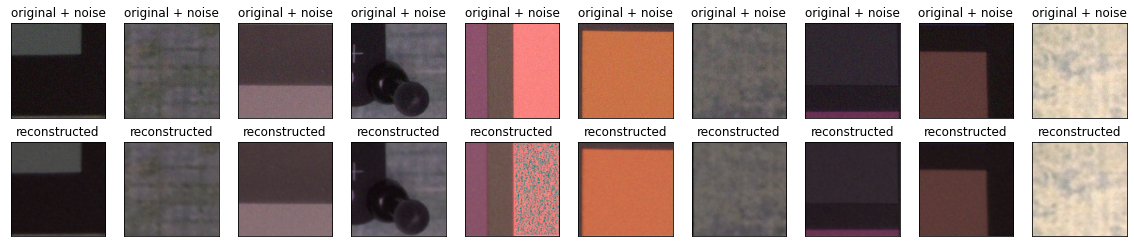

In [16]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(restore_standardised_image(test_x[i])))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(rgb_decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()


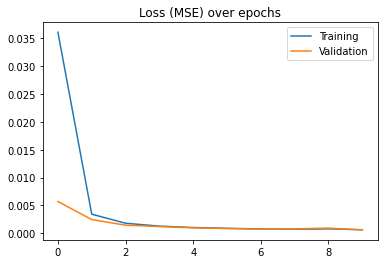

In [17]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["Training", "Validation"])
plt.title("Loss (MSE) over epochs")
plt.show()

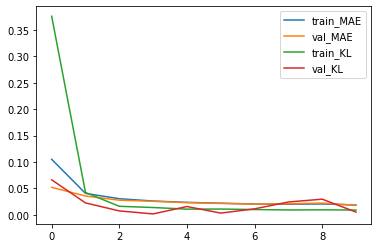

In [18]:
plt.plot(history.history["MAE"])
plt.plot(history.history["val_MAE"])
plt.plot(history.history["kullback_leibler_divergence"])
plt.plot(history.history["val_kullback_leibler_divergence"])
plt.legend(["train_MAE", "val_MAE", "train_KL", "val_KL"])
plt.show()

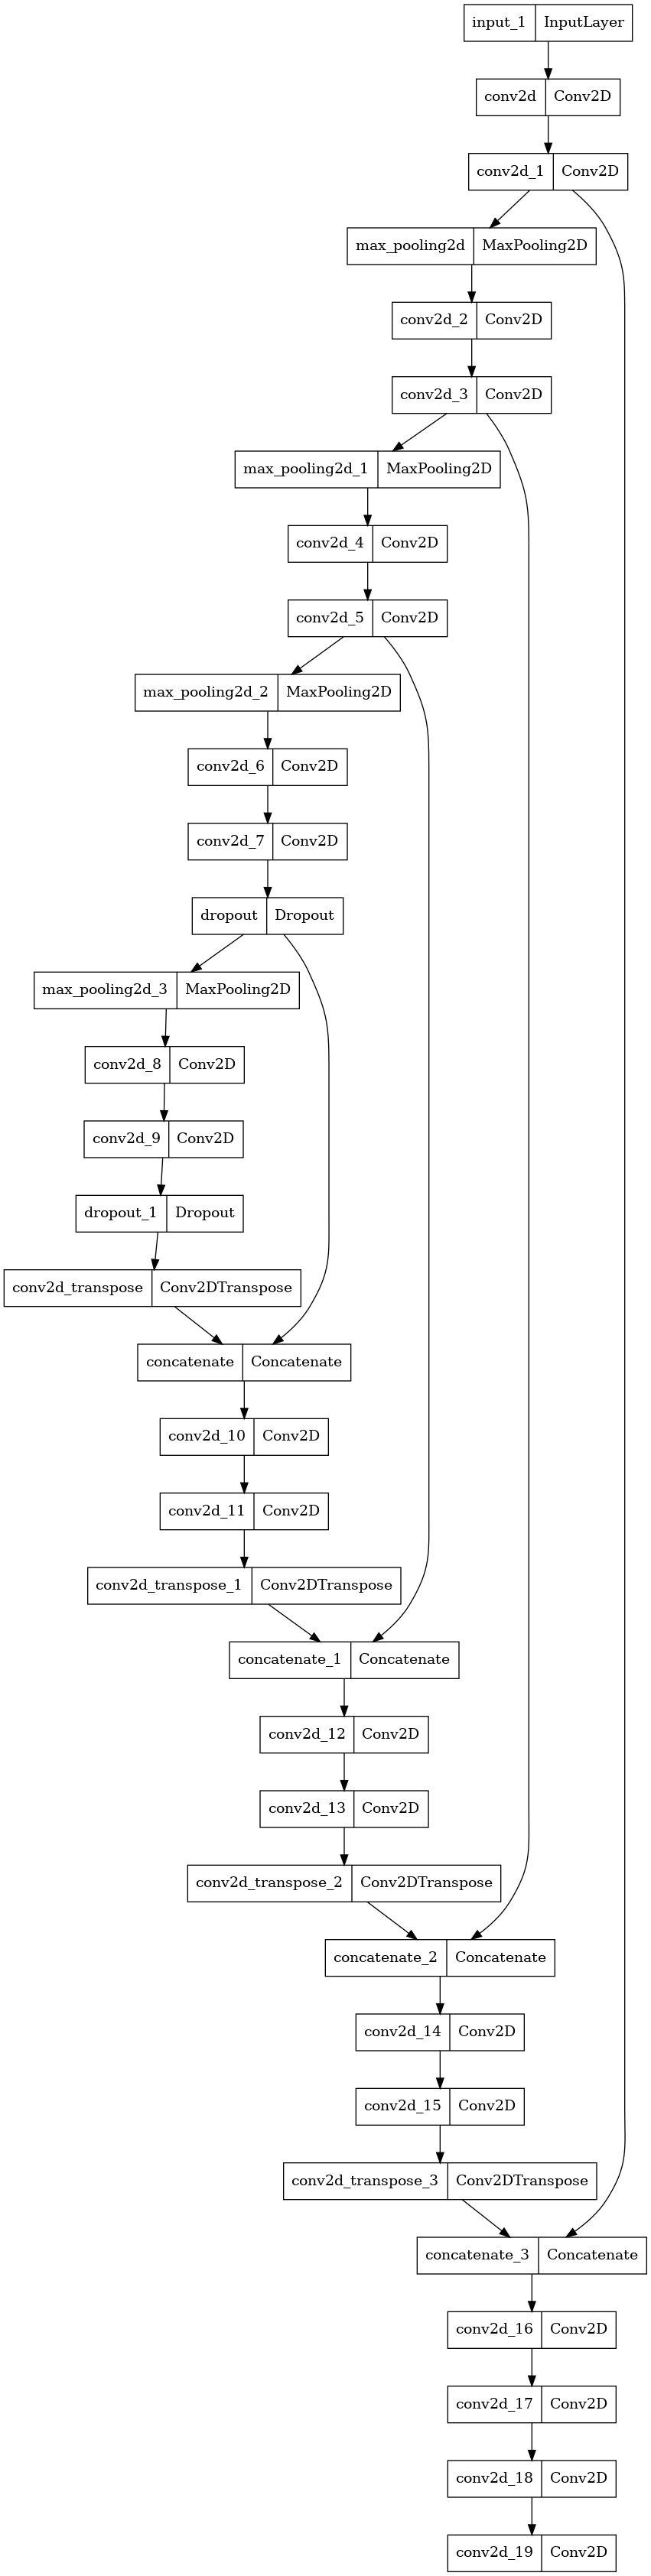

In [19]:
plot_model(unet)

In [20]:
import os
# Get file size in bytes for a given model
unet_bytes = os.stat('unet.h5').st_size
print(f"Model size in memory: {unet_bytes} B = {unet_bytes/1024} KiB = {unet_bytes/1024**2} MiB = {unet_bytes/1024**3} GiB")

Model size in memory: 103903904 B = 101468.65625 KiB = 99.09048461914062 MiB = 0.09676805138587952 GiB
